## Classifying images with pre-trained models

First, let's download three image classification models from the Apache MXNet [model zoo](http://mxnet.io/model_zoo/).
* **VGG-16**: the 2014 classification winner at the [ImageNet Large Scale Visual Recognition Challenge](http://image-net.org/challenges/LSVRC).
* **Inception v3**, an evolution of GoogleNet, the 2014 winner for object detection.
* **ResNet-152**, the 2015 winner in multiple categories.

All three models have been pre-trained on the ImageNet data set, which includes object and animal pictures sorted in 1,000 categories.

In [32]:
!wget http://data.dmlc.ml/models/imagenet/vgg/vgg16-symbol.json -O vgg16-symbol.json
!wget http://data.dmlc.ml/models/imagenet/vgg/vgg16-0000.params -O vgg16-0000.params
!wget http://data.dmlc.ml/models/imagenet/inception-bn/Inception-BN-symbol.json -O Inception-BN-symbol.json
!wget http://data.dmlc.ml/models/imagenet/inception-bn/Inception-BN-0126.params -O Inception-BN-0000.params
!wget http://data.dmlc.ml/models/imagenet/resnet/152-layers/resnet-152-symbol.json -O resnet-152-symbol.json
!wget http://data.dmlc.ml/models/imagenet/resnet/152-layers/resnet-152-0000.params -O resnet-152-0000.params
!wget http://data.dmlc.ml/models/imagenet/synset.txt -O synset.txt
!head -5 synset.txt

--2017-10-15 15:38:24--  http://data.dmlc.ml/models/imagenet/vgg/vgg16-symbol.json
Resolving data.dmlc.ml (data.dmlc.ml)... 54.208.175.7
Connecting to data.dmlc.ml (data.dmlc.ml)|54.208.175.7|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16554 (16K) [application/json]
Saving to: ‘vgg16-symbol.json’

vgg16-symbol.json   100%[===================>]  16.17K  --.-KB/s    in 0.08s   

2017-10-15 15:38:24 (203 KB/s) - ‘vgg16-symbol.json’ saved [16554/16554]

--2017-10-15 15:38:25--  http://data.dmlc.ml/models/imagenet/vgg/vgg16-0000.params
Resolving data.dmlc.ml (data.dmlc.ml)... 54.208.175.7
Connecting to data.dmlc.ml (data.dmlc.ml)|54.208.175.7|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 553431792 (528M)
Saving to: ‘vgg16-0000.params’

vgg16-0000.params   100%[===================>] 527.79M  18.1MB/s    in 34s     

2017-10-15 15:38:58 (15.7 MB/s) - ‘vgg16-0000.params’ saved [553431792/553431792]

--2017-10-15 15:39:01--  http://data.dm

In [17]:
import mxnet as mx
import numpy as np
import cv2,sys,time
from collections import namedtuple
from IPython.core.display import Image, display

print "MXNet version: %s"  % mx.__version__

MXNet version: 0.11.0


Now, let's load a model. Here are the differents steps:
* load **weights** and **model description** from file: MXNet calls this a **checkpoint**. In return, we get a *Symbol* object and the weights, a.k.a model parameters.
* create a new *Module* and assign it the input *Symbol*. We could also a *context* parameter indicating where we want to run the model: the default value is cpu(0), but we’d use gpu(0) to run this on a GPU.
* bind the input *Symbol* to input data. We have to call it ‘data’ because that’s its name in the **input layer** of the network (look at the first few lines of the JSON file).
* define the **shape** of ‘data’ as 1 x 3 x 224 x 224. ‘224 x 224’ is the image resolution, that’s how the model was trained. ‘3’ is the number of channels : red, green and blue (in this order). ‘1’ is the batch size: we’ll predict one image at a time.

We also need to load the 1,000 categories stored in the synset.txt file. We'll need the actual descriptions at prediction time.

In [18]:
def loadModel(modelname):
        sym, arg_params, aux_params = mx.model.load_checkpoint(modelname, 0)
        arg_params['prob_label'] = arg_params['softmax_label'] = mx.nd.array([0])
        mod = mx.mod.Module(symbol=sym)
        #mod = mx.mod.Module(symbol=sym, context=mx.gpu(0))
        mod.bind(for_training=False, data_shapes=[('data', (1,3,224,224))])
        mod.set_params(arg_params, aux_params)
        return mod

def loadCategories():
        synsetfile = open('synset.txt', 'r')
        synsets = []
        for l in synsetfile:
                synsets.append(l.rstrip())
        return synsets


Now let's write a function to load an image from file. Remember that the model expects a 4-dimension *NDArray* holding the red, green and blue channels of a single 224 x 224 image. We’re going to use the **OpenCV** library to build this *NDArray* from our input image.

Here are the steps:
* read the image: this will return a **numpy array** shaped as (image height, image width, 3), with the three channels in **BGR** order (blue, green and red).
* convert the image to **RGB**.
* resize the image to **224 x 224**.
* **reshape** the array from (image height, image width, 3) to (3, image height, image width).
* add a **fourth dimension** and build the *NDArray*.

In [19]:
def prepareNDArray(filename):
        img = cv2.imread(filename)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224, 224,))
        img = np.swapaxes(img, 0, 2)
        img = np.swapaxes(img, 1, 2)
        img = img[np.newaxis, :]
        array = mx.nd.array(img)
        #print array.shape
        return array

Let's take care of prediction. Our parameters are an image, a model, a list of categories and the number of top categories we'd like to return. 

Remember that a *Module* object must feed data to a model in **batches**: the common way to do this is to use a **data iterator**. Here, we’d like to predict a single image, so although we could use a data iterator, it’d probably be overkill. Instead, let's create a named tuple, called *Batch*, which will act as a fake iterator by returning our input *NDArray* when its 'data' attribute is referenced.

Once the image has been forwarded, the model outputs an *NDArray* holding **1,000 probabilities**, corresponding to the 1,000 categories it has been trained on: the *NDArray* has only one line since batch size is equal to 1. 

Let’s turn this into an array with *squeeze()*. Then, using *argsort()*, we create a second array holding the **index** of these probabilities sorted in **descending order**. Finally, we return the top n categories and their description.

In [20]:
def predict(filename, model, categories, n):
        array = prepareNDArray(filename)
        Batch = namedtuple('Batch', ['data'])
        t1 = time.time()
        model.forward(Batch([array]))
        prob = model.get_outputs()[0].asnumpy()
        t2 = time.time()
        print("Predicted in %.2f microseconds" % (t2-t1))
        #print prob.shape
        prob = np.squeeze(prob)
        sortedprobindex = np.argsort(prob)[::-1]
        #print sortedprobindex.shape
        
        topn = []
        for i in sortedprobindex[0:n]:
                topn.append((prob[i], categories[i]))
        return topn

Time to put everything together. Let's load all three models.

In [21]:
def init(modelname):
        model = loadModel(modelname)
        categories = loadCategories()
        return model, categories

vgg16,categories = init("vgg16")
resnet152,categories = init("resnet-152")
inceptionv3,categories = init("Inception-BN")

We can now use these models to classify our own images. Try as many as you'd like and don't forget to experiment with both CPU and GPU contexts. The difference in performance should be quite noticeable!

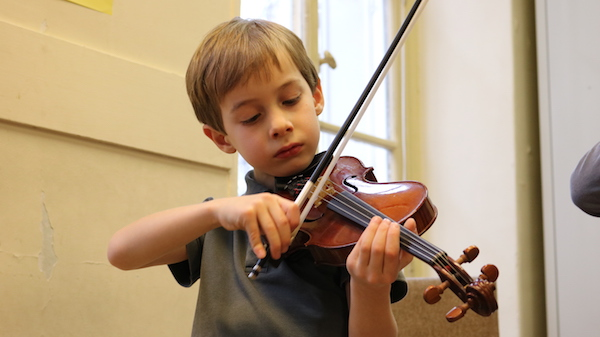

*** VGG16
Predicted in 0.90 microseconds
[(0.96869016, 'n04536866 violin, fiddle'), (0.02712068, 'n02992211 cello, violoncello'), (0.001678493, 'n02879718 bow'), (0.00057077577, 'n04517823 vacuum, vacuum cleaner'), (0.00024909462, 'n04090263 rifle')]
*** ResNet-152
Predicted in 1.04 microseconds
[(0.96921831, 'n04536866 violin, fiddle'), (0.027280878, 'n02992211 cello, violoncello'), (0.00079216302, 'n02676566 acoustic guitar'), (0.00067334715, 'n02787622 banjo'), (0.00037561322, 'n02879718 bow')]
*** Inception v3
Predicted in 0.38 microseconds
[(0.81940883, 'n04536866 violin, fiddle'), (0.15574351, 'n02992211 cello, violoncello'), (0.004448052, 'n02676566 acoustic guitar'), (0.0020717327, 'n02879718 bow'), (0.0014753051, 'n03447721 gong, tam-tam')]


In [22]:
image = "violin.jpg"

display(Image(filename=image))

topn = 5
print ("*** VGG16")
print predict(image,vgg16,categories,topn)
print ("*** ResNet-152")
print predict(image,resnet152,categories,topn)
print ("*** Inception v3")
print predict(image,inceptionv3,categories,topn)
